In [1]:
#This script analyzes counts data from the primary KO-seq mouse infectivity screen

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gridExtra)
library(extrafont)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘cowplot’ was built under R version 4.3.3”
Warning message:
“package ‘gridExtra’ was built under R version 4.3.3”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registering fonts with R



In [3]:
font_import(pattern = 'Arial')

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


Scanning ttf files in /usr/share/fonts/, /usr/local/share/fonts/ ...

Extracting .afm files from .ttf files...

/usr/share/fonts/truetype/msttcorefonts/Arial_Black.ttf
 : Arial-Black already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_Italic.ttf
 : Arial-BoldItalicMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf
 : Arial-BoldMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf
 : Arial-ItalicMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf
 : ArialMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf
 : ArialMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf
 : Arial-BoldMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_

In [4]:
#Import files

#.csv files containing upstream and downstream KO-seq read counts
my_directory <- './MouseScreen_csvs/'
my_files <- list.files(my_directory, pattern = '*_dedup_counts.csv')

#Dataframe of KO's in deletion library with corresponding plate numbers and QC information
KO_list <- read.csv('./KO_Plate_QC_List.csv', header = TRUE)

#Dataframe containing information for C. neoformans H99 protein-coding genes, from FungiDB66
gene_info_df <- read.csv('./GeneInfo_FungiDB66.csv', header = TRUE)

In [5]:
#Mutants in KO collection later found to be diploid
diploid_set <- c('CNAG_01883', 'CNAG_00039', 'CNAG_01040', 'CNAG_00106', 'CNAG_00394', 'CNAG_04186', 'CNAG_04524', 'CNAG_03114',
                 'CNAG_07380', 'CNAG_02335', 'CNAG_03227', 'CNAG_03308', 'CNAG_01175', 'CNAG_02655', 'CNAG_02473', 'CNAG_03965',
                 'CNAG_03452', 'CNAG_00110', 'CNAG_00542', 'CNAG_01658', 'CNAG_03171', 'CNAG_04241', 'CNAG_05971', 'CNAG_06027')

In [6]:
#Pull out relevant columns from gene_info_df
gene_info_df <- gene_info_df %>% rename(Gene = Gene.ID, GeneName = Gene.Name.or.Symbol, ProductDescription = Product.Description) %>%
    select(Gene, GeneName, ProductDescription)

In [7]:
#Set up empty dataframe to contain upstream and downstream KO-seq counts for each mutant
my_df <- data.frame(Gene = factor(),
                    Sample = factor(),
                    PoolName = factor(),
                    Condition = factor(),
                    UpCount = integer(),
                    DownCount = integer())

In [8]:
#Script below parses KO-seq .csv files, pulls relevant metadata and read counts, and writes everything to my_df
#Note that .csv files had been renamed to a standardized format that is necessary for the script below to parse
#Relevant fields in filenames are separate by underscores and are:
#[IrrelevantNumber]_PoolIdentifier_MouseIdentifier_KOseqJunction_[RemainderIrrelevant]

#Iterate through .csv files
for(file_name1 in my_files){
    
    #Start with files for downstream KO-seq counts
    if(grepl('_Down_', file_name1)){

        #Make general sample name
        sample_name <- paste(tail(strsplit(strsplit(file_name1, '_Down_')[[1]][[1]], '_')[[1]], -1), collapse = '_')

        #Pull pool and condition (mouse, PreInput, or PostInput) from file name fields 1 and 2
        pool_name <- strsplit(sample_name, '_')[[1]][[1]]
        condition <- strsplit(sample_name, '_')[[1]][[2]]

        #Find file with corresponding upstream KO-seq counts
        for(file_name2 in my_files){
            if(grepl('_Up_', file_name2) & paste(tail(strsplit(strsplit(file_name2, '_Up_')[[1]][[1]], '_')[[1]], -1), collapse = '_') == sample_name){
                
                #Create dataframes containing downstream or upstream counts for each mutant
                down_df <- read.csv(paste(my_directory, file_name1, sep = ''), header = TRUE) %>% select(c('Gene', 'Count')) %>% rename(DownCount = Count)
                up_df <- read.csv(paste(my_directory, file_name2, sep = ''), header = TRUE) %>% select(c('Gene', 'Count')) %>% rename(UpCount = Count)

                #Merge downstream and upstream dfs, pull in KO data from KO_list, rename and reorganize columns,
                #convert NA counts to 0, merge in FungiDB gene info, add all rows to my_df
                merged_df <- merge(down_df, up_df, by = 'Gene', all = TRUE)
                merged_df <- merge(merged_df, KO_list, by = 'Gene', all.y = TRUE)
                merged_df <- mutate(merged_df,
                                    Sample = factor(sample_name),
                                    PoolName = factor(pool_name),
                                    Condition = factor(condition)) %>%
                select(Gene, Plate, QC, Sample, PoolName, Condition, UpCount, DownCount)
                merged_df[is.na(merged_df)] <- as.double(0)
                merged_df <- merge(merged_df, gene_info_df, by = 'Gene', all.x = TRUE)
                my_df <- rbind(my_df, merged_df)
            }
        }
    }
}

In [9]:
#Filter out genes that aren't in current genome annotation, that failed QC, or that are likely diploids
my_df <- my_df %>% filter(Gene %in% gene_info_df$Gene, !(QC == "Fail"), !(Gene %in% diploid_set))

In [10]:
#Give pools a more human-readable name (numbered 1-10)

pool_df <- data.frame(PoolName = c('Plates0004', 'Plates0509', 'Plates1014', 'Plates1519', 'Plates2024',
                                  'Plates2529', 'Plates3034', 'Plates3539', 'Plates4044', 'Plates4548'),
                     Pool = c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
pool_df$PoolPlates <- list(as.character(c(0:4)), as.character(c(5:9)), as.character(c(10:14)), 
                           as.character(c(15:19)), as.character(c(20:24)), as.character(c(25:29)),
                           as.character(c(30:34)), as.character(c(35:39)), as.character(c(40:44)),
                           as.character(c(45:48)))

my_df <- left_join(my_df, pool_df, by = 'PoolName')
my_df <- my_df %>% relocate(Pool, .after = Sample) %>% relocate(PoolPlates, .after = Pool)
my_df <- my_df %>% rowwise() %>% filter(Plate %in% PoolPlates) %>% ungroup()

In [11]:
#Calculate normalized counts and log2 normalized counts for each sample

my_df <- my_df %>% mutate(SummedCounts = UpCount + DownCount) %>%
    group_by(Sample) %>%
    mutate(NormalizedCounts = ((SummedCounts/sum(SummedCounts))*1000000) + 1,
           log2NormCounts = log2(NormalizedCounts)) %>%
    ungroup()

In [12]:
#Make separate dataframes for each library subpool

pool1_df <- my_df %>% filter(Pool == 1)
pool2_df <- my_df %>% filter(Pool == 2)
pool3_df <- my_df %>% filter(Pool == 3)
pool4_df <- my_df %>% filter(Pool == 4)
pool5_df <- my_df %>% filter(Pool == 5)
pool6_df <- my_df %>% filter(Pool == 6)
pool7_df <- my_df %>% filter(Pool == 7)
pool8_df <- my_df %>% filter(Pool == 8)
pool9_df <- my_df %>% filter(Pool == 9)
pool10_df <- my_df %>% filter(Pool == 10)

In [13]:
#Function to calculate log2 fold change between a mouse and its relevant control

calc_L2FC <- function(mouse, control){
    L2FC <- mouse - control
}

In [14]:
#Function to calculate modified Z score (Zm) from the set of muatant log2 fold changes withiin a single mouse

calc_Zm <- function(L2FCs){
    (0.6745*(L2FCs - median(L2FCs)))/median(abs(L2FCs - median(L2FCs)))
}

In [15]:
#Function to calculate Z scores from log2 fold changes within a single mouse, given a user-specified mean and sd

calc_Z <- function(L2FCs, m, stdev){
    (L2FCs-m)/stdev
}

In [16]:
#Function to analyze each mouse dataframe separately

analyze_mouse <- function(pool_input_df){

#Make a dataframe with just mutants and their summed counts. Reason for this is want counts later to filter out those with low reads
summed_counts_df <- pool_input_df %>% select(Gene, Condition, SummedCounts) %>%
        pivot_wider(names_from = Condition, values_from = SummedCounts) %>%
        rename_with(.fn = function(.x){paste0(.x, '_Counts')}, .cols = -c(Gene))

#Make dataframe with just log2 normalized counts
log2norm_counts_df <- pool_input_df %>% select(Gene, Condition, log2NormCounts) %>%
        pivot_wider(names_from = Condition, values_from = log2NormCounts) %>%
        rename_with(.fn = function(.x){paste0(.x, '_log2NormCounts')}, .cols = -c(Gene))

#Merge the summed counts and log2 normalized counts dataframes
pool_output_df <- merge(summed_counts_df, log2norm_counts_df, by = 'Gene')
colnames(pool_output_df) <- gsub(x = colnames(pool_output_df), pattern = 'Mouse0_', replacement = 'Mouse1_')
colnames(pool_output_df) <- gsub(x = colnames(pool_output_df), pattern = 'MouseL_', replacement = 'Mouse2_')
colnames(pool_output_df) <- gsub(x = colnames(pool_output_df), pattern = 'MouseR_', replacement = 'Mouse3_')
colnames(pool_output_df) <- gsub(x = colnames(pool_output_df), pattern = 'MouseLL_', replacement = 'Mouse4_')
colnames(pool_output_df) <- gsub(x = colnames(pool_output_df), pattern = 'MouseLR_', replacement = 'Mouse5_')

#Filter out mutants with <=10 raw counts or <=10 counts per million
pool_output_df <- pool_output_df %>% filter(PostInput_Counts > 10, PostInput_log2NormCounts > log2(10))

#Loop through each mouse and make various calculations. In brief to calculate what we'll call an "adjusted Z score" (Zadj), first calculate
#L2FCs for each mutant in each mouse (relative to the in vitro control culture). Then use a modified (median-based) Z-score (Zm) to identify
#outliers and temporarily remove them. Calculate population mean and sd based on that set of mutants without outliers. Then, bring back
#the full dataset of L2FCs, including outliers, and convert those to Z-scores using the calculated mean and sd, calling this value Zadj.

for(i in 1:length(grep('Mouse.*_log2NormCounts', colnames(pool_output_df)))){
    col_index <- grep('Mouse.*_log2NormCounts', colnames(pool_output_df))[i] #Index of relevant mouse column
    mouse_log2NormCounts <- colnames(pool_output_df)[col_index] #Variable storing mouse log2NormCounts column
    control_log2NormCounts <- 'PostInput_log2NormCounts' #Variable storing control log2NormCounts column
    
    #Assign column names for L2FC, Zm, and Zadj
    new_L2FC_colname <- paste0(strsplit(mouse_log2NormCounts, '_')[[1]][[1]], '_L2FC')
    new_Zm_colname <- paste0(strsplit(mouse_log2NormCounts, '_')[[1]][[1]], '_Zm')
    new_Zadj_colname <- paste0(strsplit(mouse_log2NormCounts, '_')[[1]][[1]], '_Zadj')
    
    #Calculate L2FC, Zm
    pool_output_df[new_L2FC_colname] <- calc_L2FC(pool_output_df[[mouse_log2NormCounts]], pool_output_df[[control_log2NormCounts]])
    pool_output_df[new_Zm_colname] <- calc_Zm(pool_output_df[[new_L2FC_colname]])
    
    #Make new df without outliers (defined by absolute value of Zm < 3.5). Find mean and sd of dataset without outliers
    df_no_outliers <- pool_output_df[abs(pool_output_df[[new_Zm_colname]]) < 3.5,]
    mean_no_outliers <- mean(df_no_outliers[[new_L2FC_colname]])
    sd_no_outliers <- sd(df_no_outliers[[new_L2FC_colname]])
    
    #Calculate Zadj for ALL datapoints including outliers. Zadj is defined as Z score using mean and sd from dataset WIITHOUT outliers
    pool_output_df[new_Zadj_colname] <- calc_Z(pool_output_df[[new_L2FC_colname]], mean_no_outliers, sd_no_outliers)
}

#Calculate mean Zadj across replicate mice
pool_output_df <- pool_output_df %>% rowwise() %>% mutate(Avg_Zadj = mean(c_across(grep('Mouse.*_Zadj$', colnames(.))))) %>%
                        ungroup()
}

In [17]:
#Run each pool through the analyze_mouse function

pool1_df2 <- analyze_mouse(pool1_df)
pool2_df2 <- analyze_mouse(pool2_df)
pool3_df2 <- analyze_mouse(pool3_df)
pool4_df2 <- analyze_mouse(pool4_df)
pool5_df2 <- analyze_mouse(pool5_df)
pool6_df2 <- analyze_mouse(pool6_df)
pool7_df2 <- analyze_mouse(pool7_df)
pool8_df2 <- analyze_mouse(pool8_df)
pool9_df2 <- analyze_mouse(pool9_df)
pool10_df2 <- analyze_mouse(pool10_df)

In [18]:
#Combine mouse data into a single df

mouse_combined_df <- bind_rows(pool1_df2, pool2_df2, pool3_df2, pool4_df2, pool5_df2, pool6_df2, pool7_df2,
                               pool8_df2, pool9_df2, pool10_df2)

In [19]:
#Select columns we care about for export

mouse_data <- mouse_combined_df %>% select(Gene,
                                           PostInput_Counts, Mouse1_Counts, Mouse2_Counts, Mouse3_Counts, Mouse4_Counts, Mouse5_Counts,
                                           PostInput_log2NormCounts, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts,
                                           Mouse4_log2NormCounts, Mouse5_log2NormCounts,
                                           Mouse1_L2FC, Mouse2_L2FC, Mouse3_L2FC, Mouse4_L2FC, Mouse5_L2FC,
                                           Mouse1_Zadj, Mouse2_Zadj, Mouse3_Zadj, Mouse4_Zadj, Mouse5_Zadj, Avg_Zadj)

In [20]:
#Save mouse analysis as csv

#write.csv(mouse_data, '/output_directory/KOLibrary_MouseScreen_Primary.csv')

In [21]:
#Want to look at correlations of mutant abundances between pairs of replicate mice

#Create df with log2NormCounts for each replicate mouse
pool1_log2NormCounts_cor_df <- pool1_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool1_log2NormCounts_cor_df <- as.data.frame(pool1_log2NormCounts_cor_df)
row.names(pool1_log2NormCounts_cor_df) <- pool1_log2NormCounts_cor_df$Gene
pool1_log2NormCounts_cor_df <- pool1_log2NormCounts_cor_df[,-1]

#Calculate correlation matrix
pool1_log2NormCounts_cor_df <- cor(pool1_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')

#Select unique pairwise correlation from matrix
pool1_lower_tri_indices <- lower.tri(pool1_log2NormCounts_cor_df, diag = FALSE)
pool1_cor_row_names <- rownames(pool1_log2NormCounts_cor_df)[row(pool1_log2NormCounts_cor_df)[pool1_lower_tri_indices]]
pool1_cor_col_names <- colnames(pool1_log2NormCounts_cor_df)[col(pool1_log2NormCounts_cor_df)[pool1_lower_tri_indices]]

#Write data to correlation table
pool1_log2NormCounts_cor_table <- data.frame(MouseA = pool1_cor_row_names,
                              MouseB = pool1_cor_col_names,
                              Pearsonr = pool1_log2NormCounts_cor_df[pool1_lower_tri_indices],
                              Pool = 1)

#Repeat for other 9 subpools

pool2_log2NormCounts_cor_df <- pool2_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool2_log2NormCounts_cor_df <- as.data.frame(pool2_log2NormCounts_cor_df)
row.names(pool2_log2NormCounts_cor_df) <- pool2_log2NormCounts_cor_df$Gene
pool2_log2NormCounts_cor_df <- pool2_log2NormCounts_cor_df[,-1]
pool2_log2NormCounts_cor_df <- cor(pool2_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool2_lower_tri_indices <- lower.tri(pool2_log2NormCounts_cor_df, diag = FALSE)
pool2_cor_row_names <- rownames(pool2_log2NormCounts_cor_df)[row(pool2_log2NormCounts_cor_df)[pool2_lower_tri_indices]]
pool2_cor_col_names <- colnames(pool2_log2NormCounts_cor_df)[col(pool2_log2NormCounts_cor_df)[pool2_lower_tri_indices]]
pool2_log2NormCounts_cor_table <- data.frame(MouseA = pool2_cor_row_names,
                              MouseB = pool2_cor_col_names,
                              Pearsonr = pool2_log2NormCounts_cor_df[pool2_lower_tri_indices],
                              Pool = 2)

pool3_log2NormCounts_cor_df <- pool3_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool3_log2NormCounts_cor_df <- as.data.frame(pool3_log2NormCounts_cor_df)
row.names(pool3_log2NormCounts_cor_df) <- pool3_log2NormCounts_cor_df$Gene
pool3_log2NormCounts_cor_df <- pool3_log2NormCounts_cor_df[,-1]
pool3_log2NormCounts_cor_df <- cor(pool3_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool3_lower_tri_indices <- lower.tri(pool3_log2NormCounts_cor_df, diag = FALSE)
pool3_cor_row_names <- rownames(pool3_log2NormCounts_cor_df)[row(pool3_log2NormCounts_cor_df)[pool3_lower_tri_indices]]
pool3_cor_col_names <- colnames(pool3_log2NormCounts_cor_df)[col(pool3_log2NormCounts_cor_df)[pool3_lower_tri_indices]]
pool3_log2NormCounts_cor_table <- data.frame(MouseA = pool3_cor_row_names,
                              MouseB = pool3_cor_col_names,
                              Pearsonr = pool3_log2NormCounts_cor_df[pool3_lower_tri_indices],
                              Pool = 3)

pool4_log2NormCounts_cor_df <- pool4_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool4_log2NormCounts_cor_df <- as.data.frame(pool4_log2NormCounts_cor_df)
row.names(pool4_log2NormCounts_cor_df) <- pool4_log2NormCounts_cor_df$Gene
pool4_log2NormCounts_cor_df <- pool4_log2NormCounts_cor_df[,-1]
pool4_log2NormCounts_cor_df <- cor(pool4_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool4_lower_tri_indices <- lower.tri(pool4_log2NormCounts_cor_df, diag = FALSE)
pool4_cor_row_names <- rownames(pool4_log2NormCounts_cor_df)[row(pool4_log2NormCounts_cor_df)[pool4_lower_tri_indices]]
pool4_cor_col_names <- colnames(pool4_log2NormCounts_cor_df)[col(pool4_log2NormCounts_cor_df)[pool4_lower_tri_indices]]
pool4_log2NormCounts_cor_table <- data.frame(MouseA = pool4_cor_row_names,
                              MouseB = pool4_cor_col_names,
                              Pearsonr = pool4_log2NormCounts_cor_df[pool4_lower_tri_indices],
                              Pool = 4)

pool5_log2NormCounts_cor_df <- pool5_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool5_log2NormCounts_cor_df <- as.data.frame(pool5_log2NormCounts_cor_df)
row.names(pool5_log2NormCounts_cor_df) <- pool5_log2NormCounts_cor_df$Gene
pool5_log2NormCounts_cor_df <- pool5_log2NormCounts_cor_df[,-1]
pool5_log2NormCounts_cor_df <- cor(pool5_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool5_lower_tri_indices <- lower.tri(pool5_log2NormCounts_cor_df, diag = FALSE)
pool5_cor_row_names <- rownames(pool5_log2NormCounts_cor_df)[row(pool5_log2NormCounts_cor_df)[pool5_lower_tri_indices]]
pool5_cor_col_names <- colnames(pool5_log2NormCounts_cor_df)[col(pool5_log2NormCounts_cor_df)[pool5_lower_tri_indices]]
pool5_log2NormCounts_cor_table <- data.frame(MouseA = pool5_cor_row_names,
                              MouseB = pool5_cor_col_names,
                              Pearsonr = pool5_log2NormCounts_cor_df[pool5_lower_tri_indices],
                              Pool = 5)

pool6_log2NormCounts_cor_df <- pool6_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool6_log2NormCounts_cor_df <- as.data.frame(pool6_log2NormCounts_cor_df)
row.names(pool6_log2NormCounts_cor_df) <- pool6_log2NormCounts_cor_df$Gene
pool6_log2NormCounts_cor_df <- pool6_log2NormCounts_cor_df[,-1]
pool6_log2NormCounts_cor_df <- cor(pool6_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool6_lower_tri_indices <- lower.tri(pool6_log2NormCounts_cor_df, diag = FALSE)
pool6_cor_row_names <- rownames(pool6_log2NormCounts_cor_df)[row(pool6_log2NormCounts_cor_df)[pool6_lower_tri_indices]]
pool6_cor_col_names <- colnames(pool6_log2NormCounts_cor_df)[col(pool6_log2NormCounts_cor_df)[pool6_lower_tri_indices]]
pool6_log2NormCounts_cor_table <- data.frame(MouseA = pool6_cor_row_names,
                              MouseB = pool6_cor_col_names,
                              Pearsonr = pool6_log2NormCounts_cor_df[pool6_lower_tri_indices],
                              Pool = 6)

pool7_log2NormCounts_cor_df <- pool7_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool7_log2NormCounts_cor_df <- as.data.frame(pool7_log2NormCounts_cor_df)
row.names(pool7_log2NormCounts_cor_df) <- pool7_log2NormCounts_cor_df$Gene
pool7_log2NormCounts_cor_df <- pool7_log2NormCounts_cor_df[,-1]
pool7_log2NormCounts_cor_df <- cor(pool7_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool7_lower_tri_indices <- lower.tri(pool7_log2NormCounts_cor_df, diag = FALSE)
pool7_cor_row_names <- rownames(pool7_log2NormCounts_cor_df)[row(pool7_log2NormCounts_cor_df)[pool7_lower_tri_indices]]
pool7_cor_col_names <- colnames(pool7_log2NormCounts_cor_df)[col(pool7_log2NormCounts_cor_df)[pool7_lower_tri_indices]]
pool7_log2NormCounts_cor_table <- data.frame(MouseA = pool7_cor_row_names,
                              MouseB = pool7_cor_col_names,
                              Pearsonr = pool7_log2NormCounts_cor_df[pool7_lower_tri_indices],
                              Pool = 7)

pool8_log2NormCounts_cor_df <- pool8_df2 %>% select(Gene, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool8_log2NormCounts_cor_df <- as.data.frame(pool8_log2NormCounts_cor_df)
row.names(pool8_log2NormCounts_cor_df) <- pool8_log2NormCounts_cor_df$Gene
pool8_log2NormCounts_cor_df <- pool8_log2NormCounts_cor_df[,-1]
pool8_log2NormCounts_cor_df <- cor(pool8_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool8_lower_tri_indices <- lower.tri(pool8_log2NormCounts_cor_df, diag = FALSE)
pool8_cor_row_names <- rownames(pool8_log2NormCounts_cor_df)[row(pool8_log2NormCounts_cor_df)[pool8_lower_tri_indices]]
pool8_cor_col_names <- colnames(pool8_log2NormCounts_cor_df)[col(pool8_log2NormCounts_cor_df)[pool8_lower_tri_indices]]
pool8_log2NormCounts_cor_table <- data.frame(MouseA = pool8_cor_row_names,
                              MouseB = pool8_cor_col_names,
                              Pearsonr = pool8_log2NormCounts_cor_df[pool8_lower_tri_indices],
                              Pool = 8)

pool9_log2NormCounts_cor_df <- pool9_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool9_log2NormCounts_cor_df <- as.data.frame(pool9_log2NormCounts_cor_df)
row.names(pool9_log2NormCounts_cor_df) <- pool9_log2NormCounts_cor_df$Gene
pool9_log2NormCounts_cor_df <- pool9_log2NormCounts_cor_df[,-1]
pool9_log2NormCounts_cor_df <- cor(pool9_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool9_lower_tri_indices <- lower.tri(pool9_log2NormCounts_cor_df, diag = FALSE)
pool9_cor_row_names <- rownames(pool9_log2NormCounts_cor_df)[row(pool9_log2NormCounts_cor_df)[pool9_lower_tri_indices]]
pool9_cor_col_names <- colnames(pool9_log2NormCounts_cor_df)[col(pool9_log2NormCounts_cor_df)[pool9_lower_tri_indices]]
pool9_log2NormCounts_cor_table <- data.frame(MouseA = pool9_cor_row_names,
                              MouseB = pool9_cor_col_names,
                              Pearsonr = pool9_log2NormCounts_cor_df[pool9_lower_tri_indices],
                              Pool = 9)

pool10_log2NormCounts_cor_df <- pool10_df2 %>% select(Gene, Mouse1_log2NormCounts, Mouse2_log2NormCounts, Mouse3_log2NormCounts, Mouse4_log2NormCounts, Mouse5_log2NormCounts)
pool10_log2NormCounts_cor_df <- as.data.frame(pool10_log2NormCounts_cor_df)
row.names(pool10_log2NormCounts_cor_df) <- pool10_log2NormCounts_cor_df$Gene
pool10_log2NormCounts_cor_df <- pool10_log2NormCounts_cor_df[,-1]
pool10_log2NormCounts_cor_df <- cor(pool10_log2NormCounts_cor_df, use = 'pairwise.complete.obs', method = 'pearson')
pool10_lower_tri_indices <- lower.tri(pool10_log2NormCounts_cor_df, diag = FALSE)
pool10_cor_row_names <- rownames(pool10_log2NormCounts_cor_df)[row(pool10_log2NormCounts_cor_df)[pool10_lower_tri_indices]]
pool10_cor_col_names <- colnames(pool10_log2NormCounts_cor_df)[col(pool10_log2NormCounts_cor_df)[pool10_lower_tri_indices]]
pool10_log2NormCounts_cor_table <- data.frame(MouseA = pool10_cor_row_names,
                              MouseB = pool10_cor_col_names,
                              Pearsonr = pool10_log2NormCounts_cor_df[pool10_lower_tri_indices],
                              Pool = 10)

In [22]:
#Compile correlation data for each of the 10 subpopols into a single df
mouse_log2NormCounts_cor_combined <- rbind(pool1_log2NormCounts_cor_table, pool2_log2NormCounts_cor_table, pool3_log2NormCounts_cor_table, pool4_log2NormCounts_cor_table, pool5_log2NormCounts_cor_table,
                                 pool6_log2NormCounts_cor_table, pool7_log2NormCounts_cor_table, pool8_log2NormCounts_cor_table, pool9_log2NormCounts_cor_table, pool10_log2NormCounts_cor_table)

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


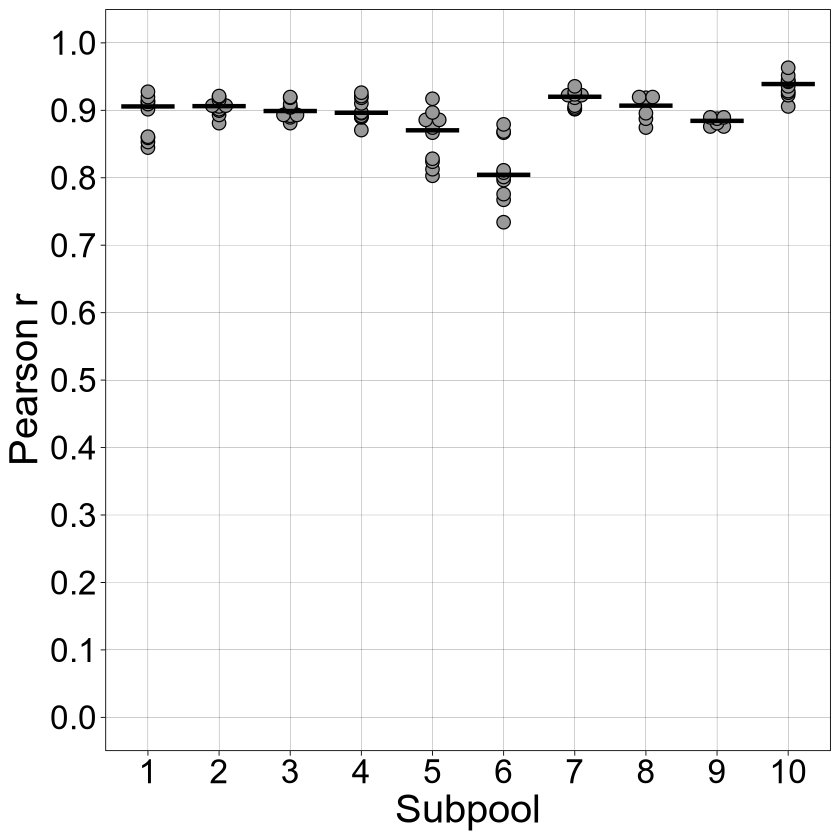

In [23]:
#Fig S6A

mouse_log2NormCounts_cor_combined %>% ggplot(aes(as.factor(Pool), Pearsonr)) +
            geom_dotplot(binaxis = 'y', stackdir = 'center', fill = 'grey60', dotsize = 20, binpositions = 'all', binwidth = 0.001) +
            scale_y_continuous(breaks = seq(0, 1, 0.1), limits = c(0,1)) +
            theme_linedraw() +
            theme(text = element_text(family = 'Arial'),
                  panel.grid.minor = element_blank(), axis.text = element_text(size = 20), axis.title = element_text(size = 24)) +
            labs(x = 'Subpool', y = 'Pearson r') +
            stat_summary(fun.y = median, geom = 'crossbar', width = 0.75,
                         size = 0.5, color = 'black')

[1] 0.9011931

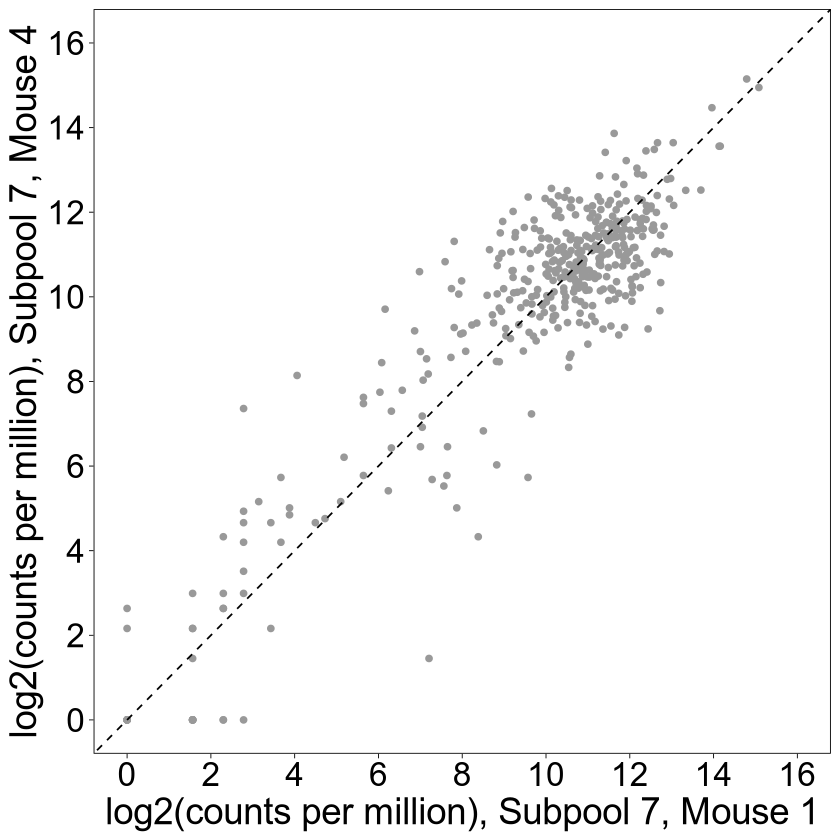

In [24]:
#Fig S6B

cor(pool7_df2$Mouse1_log2NormCounts, pool7_df2$Mouse4_log2NormCounts, use = 'pairwise.complete.obs', method = 'pearson')

pool7_df2 %>% ggplot(aes(Mouse1_log2NormCounts, Mouse4_log2NormCounts)) + geom_point(color = 'grey60') +
                scale_x_continuous(breaks = seq(0,16,2), limits = c(0,16)) +
                scale_y_continuous(breaks = seq(0,16,2), limits = c(0,16)) +
                theme_linedraw() +
                geom_abline(intercept = -0, slope = 1, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),,
                      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                axis.text = element_text(size = 20), axis.title = element_text(size = 22)) +
                labs(x = 'log2(counts per million), Subpool 7, Mouse 1', y = 'log2(counts per million), Subpool 7, Mouse 4')